In [3]:
import pandas as pd
import numpy as np
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.layers import Activation, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib
from matplotlib import pyplot as plt

In [4]:
pathway_encodings = pd.read_csv("pathway_encodings_full.csv")

In [8]:
pathway_labels = [col for col in pathway_encodings.columns if col != "CancerType" and col != "Unnamed: 0"]

In [12]:
cancer_type_map = {}
for i, ct in enumerate(set(list(pathway_encodings["CancerType"]))):
    cancer_type_map[ct] = i


In [13]:
cancer_type_map

{'LUSC-US': 0,
 'KIRC-US': 1,
 'UCEC-US': 2,
 'OV-US': 3,
 'COAD-US': 4,
 'GBM-US': 5,
 'THCA-US': 6,
 'Healthy': 7,
 'BRCA-US': 8,
 'LGG-US': 9,
 'PRAD-US': 10,
 'BLCA-US': 11,
 'SKCM-US': 12}

In [14]:
datax = pathway_encodings[pathway_labels].to_numpy()

In [20]:
datax_norm = datax / (np.max(datax, axis=0) + 0.001)

In [23]:
def to_categorical(val, n_class=12):
    result = np.zeros(n_class)
    result[val] = 1
    return result

datay = [to_categorical(cancer_type_map[t], 13) for t in list(pathway_encodings['CancerType'])]
datay = np.array(datay)
datay.shape

(5868, 13)

In [24]:
datax_norm.shape

(5868, 1657)

In [35]:
# define the classifier
X = Input((datax.shape[1],))
H1 = Dense(500)(X)
BN1 = BatchNormalization()(H1)
A1 = Activation("relu")(BN1)
D1 = Dropout(0.1)(A1)
H2 = Dense(250)(D1)
BN2 = BatchNormalization()(H2)
A2 = Activation("relu")(BN2)
D2 = Dropout(0.1)(A2)
H3 = Dense(50)(D2)
BN3 = BatchNormalization()(H3)
A3 = Activation("relu")(BN3)
D3 = Dropout(0.1)(A3)
Y = Dense(13, activation="softmax")(D3)

clf = Model(X, Y)
clf.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 1657)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 500)               829000    
_________________________________________________________________
batch_normalization_v1_3 (Ba (None, 500)               2000      
_________________________________________________________________
activation_3 (Activation)    (None, 500)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 250)               125250    
_________________________________________________________________
batch_normalization_v1_4 (Ba (None, 250)               1000      
__________

In [31]:
merged_data = [(datax_norm[i],datay[i]) for i in range(datay.shape[0])]
np.random.shuffle(merged_data)

In [33]:
test = merged_data[:1000]
train = merged_data[1000:]

In [34]:
trainx = np.array([x for (x,_) in train])
trainy = np.array([y for (_,y) in train])

In [36]:
clf.compile(optimizer=Adam(lr=0.003), loss="categorical_crossentropy", metrics=["accuracy"])

In [38]:
clf.fit(trainx, trainy, batch_size=32, epochs=20, validation_split=0.2)

Train on 3894 samples, validate on 974 samples
Epoch 1/20
3894/3894 [==============================] - 1s 276us/sample - loss: 1.3739 - acc: 0.5696 - val_loss: 2.3975 - val_acc: 0.3152
Epoch 2/20
3894/3894 [==============================] - 1s 277us/sample - loss: 1.3660 - acc: 0.5732 - val_loss: 2.2003 - val_acc: 0.3255
Epoch 3/20
3894/3894 [==============================] - 1s 278us/sample - loss: 1.3630 - acc: 0.5773 - val_loss: 2.4619 - val_acc: 0.2988
Epoch 4/20
3894/3894 [==============================] - 1s 276us/sample - loss: 1.3606 - acc: 0.5752 - val_loss: 2.4478 - val_acc: 0.3111
Epoch 5/20
3894/3894 [==============================] - 1s 284us/sample - loss: 1.3497 - acc: 0.5768 - val_loss: 2.5784 - val_acc: 0.3090
Epoch 6/20
3894/3894 [==============================] - 1s 279us/sample - loss: 1.3297 - acc: 0.5842 - val_loss: 2.5238 - val_acc: 0.2669
Epoch 7/20
3894/3894 [==============================] - 1s 272us/sample - loss: 1.3378 - acc: 0.5799 - val_loss: 2.5381 - val

In [39]:
from umap import UMAP

In [40]:
reducer = UMAP(n_components=2, n_neighbors=25)

In [41]:
umap_reduced = reducer.fit_transform(datax)

/home/lava-gpu/anaconda3/envs/ml-lava/lib/python3.7/site-packages/umap/rp_tree.py:450: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "make_euclidean_tree" failed type inference due to: Cannot unify RandomProjectionTreeNode(array(int64, 1d, C), bool, none, none, none, none) and RandomProjectionTreeNode(none, bool, array(float32, 1d, C), float64, RandomProjectionTreeNode(array(int64, 1d, C), bool, none, none, none, none), RandomProjectionTreeNode(array(int64, 1d, C), bool, none, none, none, none)) for '$46call_function.15', defined at /home/lava-gpu/anaconda3/envs/ml-lava/lib/python3.7/site-packages/umap/rp_tree.py (457)

File "../../../anaconda3/envs/ml-lava/lib/python3.7/site-packages/umap/rp_tree.py", line 457:
def make_euclidean_tree(data, indices, rng_state, leaf_size=30):
    <source elided>

        left_node = make_euclidean_tree(data, left_indices, rng_state, leaf_size)
        ^

[1] During: resolving callee type: recursive(

In [42]:
labels = [cancer_type_map[t] for t in list(pathway_encodings['CancerType'])]

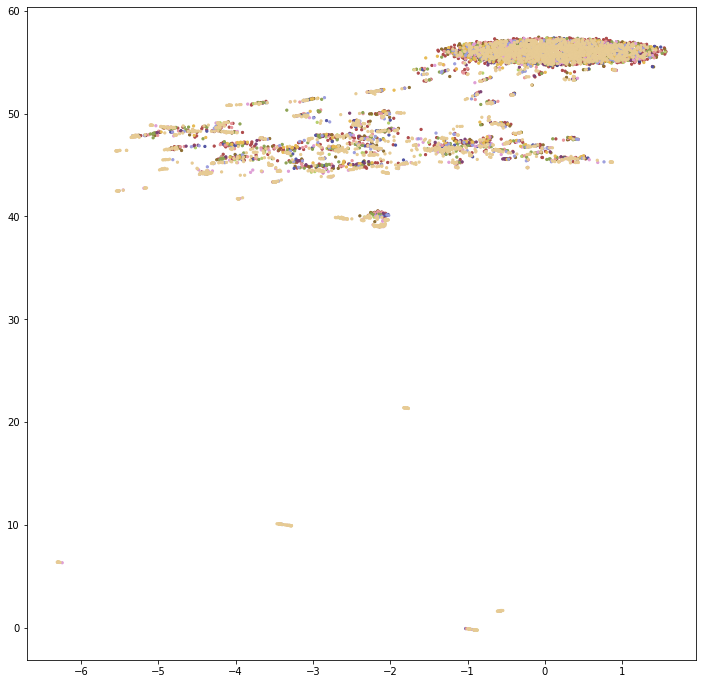

In [43]:
plt.rcParams["figure.figsize"] = (12, 12)
plt.scatter(umap_reduced[:, 0], umap_reduced[:, 1], s=5, cmap="tab20b", c=labels)
plt.show()